# 1. Load and prepare data
## 1.1 Load libraries

In [1]:
%matplotlib inline
# data manipulation libraries
import pandas as pd
import numpy as np

from time import time

# Graphs libraries
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.style.use('seaborn-white')
import seaborn as sns

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
from plotly import tools

# Libraries to study
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
#from aif360.algorithms.inprocessing import PrejudiceRemover

# ML libraries
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf

# Design libraries
from IPython.display import Markdown, display
import warnings
warnings.filterwarnings("ignore")

## 1.2. Load the data
We read previous work conducted by ProPublica and we simply write a dataset called **csty_filtered.csv** which containing all filtered features from the first part of [this analysis](https://github.com/propublica/compas-analysis/blob/master/Compas%20Analysis.ipynb). The whole description can be found [here](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm). We also create a new feature **length_of_stay** which stands for the duration between **c_jail_in** and **c_jail_out** in days.

In [2]:
compas = pd.read_csv('../output/csty_filtered.csv')
data = compas[(compas['race'] == 'Caucasian') | (compas['race'] == 'African-American')]

# 2. Data preparation
## 2.1. Prepare the data

In [3]:
Y_column = ['two_year_recid']
cat_columns = []
num_columns = []

for col in data.columns.values:
    if col in Y_column:
        continue
    elif data[col].dtypes == 'int64':
        num_columns += [col]
    else:
        cat_columns += [col]

## 2.2. Work with the feature
### 2.2.1. Encoding categorical features

In [4]:
categorical_features = cat_columns + ['two_year_recid']
# categorical_features = categorical_features 
categorical_features_idx = [np.where(data.columns.values == col)[0][0] for col in categorical_features]

del cat_columns

In [5]:
data_encoded = data.copy()

categorical_names = {}
encoders = {}

# Use Label Encoder for categorical columns (including target column)
for feature in categorical_features:
    le = LabelEncoder()
    le.fit(data_encoded[feature])
    
    data_encoded[feature] = le.transform(data_encoded[feature])
    
    categorical_names[feature] = le.classes_
    encoders[feature] = le

### 2.2.2. Scale numerical features
We use MinMaxScaler Transform here.

In [6]:
numerical_features = [c for c in data.columns.values if c not in categorical_features]

for feature in numerical_features:
    val = data_encoded[feature].values[:, np.newaxis]
    mms = MinMaxScaler().fit(val)
    data_encoded[feature] = mms.transform(val)
    encoders[feature] = mms
    
data_encoded = data_encoded.astype(float)

del num_columns

In [7]:
data_encoded.head()

,age,c_charge_degree,race,age_cat,score_text,sex,priors_count,days_b_screening_arrest,decile_score,is_recid,two_year_recid,length_of_stay
1,0.258065,0.0,0.0,0.0,1.0,1.0,0.000000,0.483333,0.222222,1.0,1.0,0.01250
2,0.096774,0.0,0.0,2.0,1.0,1.0,0.105263,0.483333,0.333333,1.0,1.0,0.00125
4,0.370968,0.0,1.0,0.0,2.0,1.0,0.368421,0.483333,0.555556,1.0,1.0,0.00750
6,0.338710,1.0,1.0,0.0,1.0,0.0,0.000000,0.483333,0.000000,0.0,0.0,0.00375
7,0.145161,0.0,1.0,0.0,1.0,1.0,0.000000,0.483333,0.333333,0.0,0.0,0.00125


In [8]:
data.head()

,age,c_charge_degree,race,age_cat,score_text,sex,priors_count,days_b_screening_arrest,decile_score,is_recid,two_year_recid,length_of_stay
1,34,F,African-American,25 - 45,Low,Male,0,-1,3,1,1,10
2,24,F,African-American,Less than 25,Low,Male,4,-1,4,1,1,1
4,41,F,Caucasian,25 - 45,Medium,Male,14,-1,6,1,1,6
6,39,M,Caucasian,25 - 45,Low,Female,0,-1,1,0,0,3
7,27,F,Caucasian,25 - 45,Low,Male,0,-1,4,0,0,1


# 3. AIF360 Introduction
## 3.1. Create dataset useing aif360

In [9]:
aif_data = BinaryLabelDataset(df=data_encoded,
                              label_names=['two_year_recid'],
                              protected_attribute_names=['race'],
                              favorable_label=1.0,
                              unfavorable_label=0.0)

In [10]:
def meta_data(dataset):
    # print out some labels, names, etc.
    display(Markdown("#### Dataset shape"))
    print(dataset.features.shape)
    display(Markdown("#### Favorable and unfavorable labels"))
    print(dataset.favorable_label, dataset.unfavorable_label)
    display(Markdown("#### Protected attribute names"))
    print(dataset.protected_attribute_names)
    display(Markdown("#### Privileged and unprivileged protected attribute values"))
    print(dataset.privileged_protected_attributes, dataset.unprivileged_protected_attributes)
    display(Markdown("#### Dataset feature names"))
    print(dataset.feature_names)

In [11]:
meta_data(aif_data)

#### Dataset shape

(5278, 11)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['race']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count', 'days_b_screening_arrest', 'decile_score', 'is_recid', 'length_of_stay']


## 3.2. Random Forest Model
We construct a random forest model as our baseline. Usually, random forest model does not require a validation set, so we just create train and test set in a ratio of 4:1.

In [12]:
np.random.seed(20211208)

aif_data_train, aif_data_test = aif_data.split([0.8], shuffle=True)

display(Markdown("#### Train Dataset shape"))
print("Race:",aif_data_train.features.shape)
display(Markdown("#### Test Dataset shape"))
print("Race:",aif_data_test.features.shape)

#### Train Dataset shape

Race: (4222, 11)


#### Test Dataset shape

Race: (1056, 11)


In [13]:
# Train and save the models
rf_aif = RandomForestClassifier().fit(aif_data_train.features,
                                      aif_data_train.labels.ravel(),
                                      sample_weight=aif_data_train.instance_weights)

In [14]:
X_test = aif_data_test.features
y_test = aif_data_test.labels.ravel()

In [15]:
# This code is based on https://www.kaggle.com/nathanlauga/ethics-and-ai-how-to-prevent-bias-on-ml?scriptVersionId=20652099&cellId=83
def get_model_performance(X_test, y_true, y_pred, probs):
    accuracy = accuracy_score(y_true, y_pred)
    matrix = confusion_matrix(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)

    return accuracy, matrix, f1, fpr, tpr, roc_auc

def plot_model_performance(model, X_test, y_true):
    y_pred = model.predict(X_test)
    probs = model.predict_proba(X_test)
    accuracy, matrix, f1, fpr, tpr, roc_auc = get_model_performance(X_test, y_true, y_pred, probs)

    display(Markdown('#### Accuracy of the model :'))
    print(accuracy)
    display(Markdown('#### F1 score of the model :'))
    print(f1)

    fig = plt.figure(figsize=(15, 6))
    ax = fig.add_subplot(1, 2, 1)
    sns.heatmap(matrix, annot=True, cmap='Blues', fmt='g')
    plt.title('Confusion Matrix')

    ax = fig.add_subplot(1, 2, 2)
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic curve')
    plt.legend(loc="lower right")

#### Accuracy of the model :

0.9696969696969697


#### F1 score of the model :

0.9693486590038314


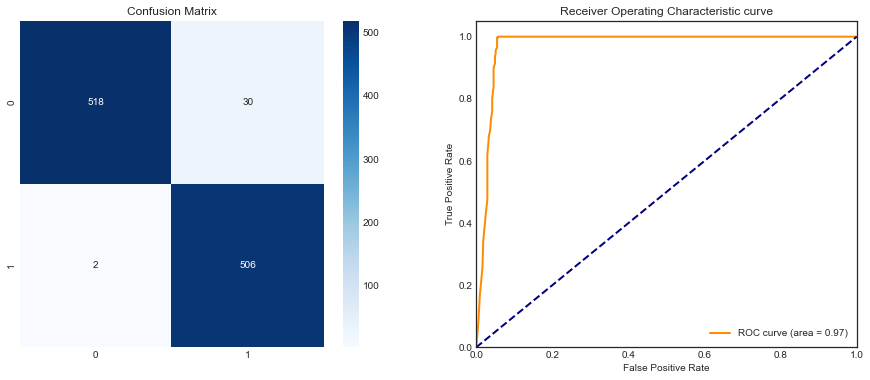

In [16]:
plot_model_performance(rf_aif, aif_data_test.features, y_test)

In [17]:
np.random.seed(20211208)

aif_data_tr, aif_data_te = aif_data.split([0.8], shuffle=True)

aif_tr = aif_data_tr.convert_to_dataframe()[0]
aif_te = aif_data_te.convert_to_dataframe()[0]

rf_aift = RandomForestClassifier().fit(aif_tr[['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 
                                               'priors_count', 'days_b_screening_arrest', 'decile_score', 'is_recid', 
                                               'length_of_stay']],
                                       aif_tr['two_year_recid'],
                                       sample_weight=aif_data_train.instance_weights)

X_test = aif_te[['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count', 'days_b_screening_arrest',
                 'decile_score', 'is_recid', 'length_of_stay']]
y_test = aif_te['two_year_recid']

In [18]:
y_pred_AA = rf_aift.predict(X_test[X_test['race']==0])
y_pred_Ca = rf_aift.predict(X_test[X_test['race']==1])
y_test_AA = aif_te[aif_te['race']==0]['two_year_recid']
y_test_Ca = aif_te[aif_te['race']==1]['two_year_recid']

display(Markdown('#### Calibration of the model :'))
print(metrics.accuracy_score(y_test_AA, y_pred_AA)-metrics.accuracy_score(y_test_Ca, y_pred_Ca))

#### Calibration of the model :

-0.0251237412527735


The baseline model has some really good metrics.
# 4. Bias and fairness
## 4.1 Metrics
AIF360 provides some metrics for us to check model fairness. I will use 5 metrics:
* Statistical Parity Difference
* Equal Opportunity Difference
* Average Absolute Odds Difference
* Disparate Impact
* Theil Index

In [19]:
# This DataFrame is created to stock differents models and fair metrics that we produce in this notebook
algo_metrics = pd.DataFrame(columns=['model', 'fair_metrics', 'prediction', 'probs'])

def add_to_df_algo_metrics(algo_metrics, model, fair_metrics, preds, probs, name):
    return algo_metrics.append(pd.DataFrame(data=[[model, fair_metrics, preds, probs]], columns=['model', 'fair_metrics', 'prediction', 'probs'], index=[name]))

In [20]:
# This code is based on https://www.kaggle.com/nathanlauga/ethics-and-ai-how-to-prevent-bias-on-ml?scriptVersionId=20652099&cellId=87
def fair_metrics(dataset, pred, pred_is_dataset=False):
    if pred_is_dataset:
        dataset_pred = pred
    else:
        dataset_pred = dataset.copy()
        dataset_pred.labels = pred
    
    cols = ['statistical_parity_difference', 'equal_opportunity_difference', 'average_abs_odds_difference',  'disparate_impact', 'theil_index']
    obj_fairness = [[0,0,0,1,0]]
    
    fair_metrics = pd.DataFrame(data=obj_fairness, index=['objective'], columns=cols)
    
    for attr in dataset_pred.protected_attribute_names:
        idx = dataset_pred.protected_attribute_names.index(attr)
        privileged_groups =  [{attr:dataset_pred.privileged_protected_attributes[idx][0]}] 
        unprivileged_groups = [{attr:dataset_pred.unprivileged_protected_attributes[idx][0]}] 
        
        classified_metric = ClassificationMetric(dataset, 
                                                     dataset_pred,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)
        
        metric_pred = BinaryLabelDatasetMetric(dataset_pred,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)

        acc = classified_metric.accuracy()
        
        row = pd.DataFrame([[metric_pred.mean_difference(),
                                classified_metric.equal_opportunity_difference(),
                                classified_metric.average_abs_odds_difference(),
                                metric_pred.disparate_impact(),
                                classified_metric.theil_index()]],
                           columns  = cols,
                           index = [attr]
                          )
        fair_metrics = fair_metrics.append(row)    
    
    fair_metrics = fair_metrics.replace([-np.inf, np.inf], 2)
        
    return fair_metrics

def plot_fair_metrics(fair_metrics):
    fig, ax = plt.subplots(figsize=(20,4), ncols=5, nrows=1)

    plt.subplots_adjust(
        left    =  0.125, 
        bottom  =  0.1, 
        right   =  0.9, 
        top     =  0.9, 
        wspace  =  .5, 
        hspace  =  1.1
    )

    y_title_margin = 1.2

    plt.suptitle("Fairness metrics", y = 1.09, fontsize=20)
    sns.set(style="dark")

    cols = fair_metrics.columns.values
    obj = fair_metrics.loc['objective']
    size_rect = [0.2,0.2,0.2,0.4,0.25]
    rect = [-0.1,-0.1,-0.1,0.8,0]
    bottom = [-1,-1,-1,0,0]
    top = [1,1,1,2,1]
    bound = [[-0.1,0.1],[-0.1,0.1],[-0.1,0.1],[0.8,1.2],[0,0.25]]

    display(Markdown("### Check bias metrics :"))
    display(Markdown("A model can be considered bias if just one of these five metrics show that this model is biased."))
    for attr in fair_metrics.index[1:len(fair_metrics)].values:
        display(Markdown("#### For the %s attribute :"%attr))
        check = [bound[i][0] < fair_metrics.loc[attr][i] < bound[i][1] for i in range(0,5)]
        display(Markdown("With default thresholds, bias against unprivileged group detected in **%d** out of 5 metrics"%(5 - sum(check))))

    for i in range(0,5):
        plt.subplot(1, 5, i+1)
        ax = sns.barplot(x=fair_metrics.index[1:len(fair_metrics)], y=fair_metrics.iloc[1:len(fair_metrics)][cols[i]])
        
        for j in range(0,len(fair_metrics)-1):
            a, val = ax.patches[j], fair_metrics.iloc[j+1][cols[i]]
            marg = -0.2 if val < 0 else 0.1
            ax.text(a.get_x()+a.get_width()/5, a.get_y()+a.get_height()+marg, round(val, 3), fontsize=15,color='black')

        plt.ylim(bottom[i], top[i])
        plt.setp(ax.patches, linewidth=0)
        ax.add_patch(patches.Rectangle((-5,rect[i]), 10, size_rect[i], alpha=0.3, facecolor="green", linewidth=1, linestyle='solid'))
        plt.axhline(obj[i], color='black', alpha=0.3)
        plt.title(cols[i])
        ax.set_ylabel('')    
        ax.set_xlabel('')

In [21]:
# This code is based on https://www.kaggle.com/nathanlauga/ethics-and-ai-how-to-prevent-bias-on-ml?scriptVersionId=20652099&cellId=88
def get_fair_metrics_and_plot(data, model, plot=True, model_aif=False):
    pred = model.predict(data).labels if model_aif else model.predict(data.features)
    # fair_metrics function available in the metrics.py file
    fair = fair_metrics(data, pred)
    
    if plot:
        # plot_fair_metrics function available in the visualisations.py file
        # The visualisation of this function is inspired by the dashboard on the demo of IBM aif360 
        plot_fair_metrics(fair)
        display(fair)
    
    return fair

### Bias metrics for the Race model

### Check bias metrics :

A model can be considered bias if just one of these five metrics show that this model is biased.

#### For the race attribute :

With default thresholds, bias against unprivileged group detected in **2** out of 5 metrics

,statistical_parity_difference,equal_opportunity_difference,average_abs_odds_difference,disparate_impact,theil_index
objective,0.000000,0.0000,0.0000,1.000000,0.000000
race,0.122433,-0.0059,0.0287,1.283344,0.012196


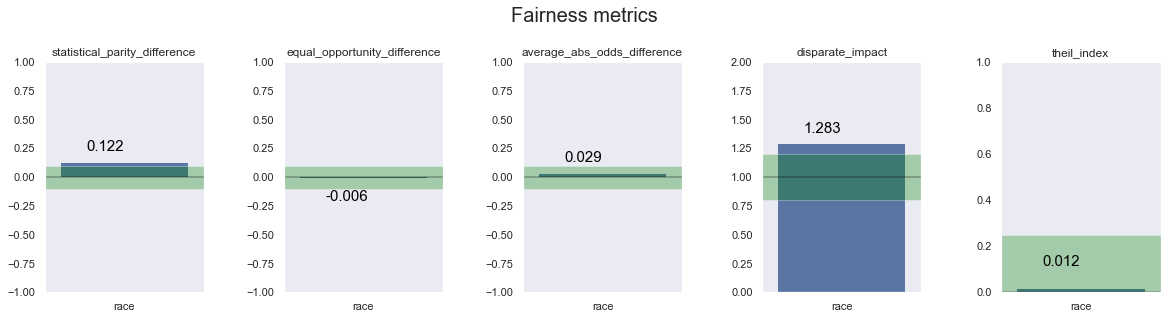

In [22]:
display(Markdown('### Bias metrics for the Race model'))
fair = get_fair_metrics_and_plot(aif_data_test, rf_aif)

As we can see this model is not really biased, but it can be better and for this example we will look how to mitigate those bias.

In [23]:
data_test = aif_data_test
data_train = aif_data_train
rf = rf_aif

probs = rf.predict_proba(data_test.features)
preds = rf.predict(data_test.features)
algo_metrics = add_to_df_algo_metrics(algo_metrics, rf, fair, preds, probs, 'Origin')

In [24]:
algo_metrics

,model,fair_metrics,prediction,probs
Origin,"(DecisionTreeClassifier(max_features='auto', r...",statistical_parity_difference equa...,"[1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[[0.16, 0.84], [0.19, 0.81], [0.11, 0.89], [0...."


## 4.2. Other algorithms

### 4.2.2. Fairness-aware Classifier with Prejudice Remover Regularizer

In [25]:
%run A5.py

<Figure size 432x288 with 0 Axes>

In [26]:
t0 = time()
debiased_model = PrejudiceRemover(sensitive_attr="race", eta = 25.0)
debiased_model.fit(data_train)

fair = get_fair_metrics_and_plot(data_test, debiased_model, plot=False, model_aif=True)
data_pred = debiased_model.predict(data_test)

algo_metrics = add_to_df_algo_metrics(algo_metrics, debiased_model, fair, data_pred.labels, data_pred.scores, 'PrejudiceRemover')
print('time elapsed : %.2fs'%(time()-t0))

time elapsed : 13.96s


In [27]:
display(Markdown('#### Accuracy of the model :'))
print(metrics.accuracy_score(data_test.labels, data_pred.labels))

#### Accuracy of the model :

0.9706439393939394


In [28]:
df_p = data_pred.convert_to_dataframe()[0]
df_p_AA = df_p[df_p['race']==0]
df_p_Ca = df_p[df_p['race']==1]
df_t = data_test.convert_to_dataframe()[0]
df_t_AA = df_t[df_t['race']==0]
df_t_Ca = df_t[df_t['race']==1]

display(Markdown('#### Calibration of the model :'))
print(metrics.accuracy_score(df_t_AA['two_year_recid'], df_p_AA['two_year_recid'])-
      metrics.accuracy_score(df_t_Ca['two_year_recid'], df_p_Ca['two_year_recid']))

#### Calibration of the model :

-0.023587642942481613


In [30]:
def compare_fair_metrics(algo_metrics, attr='race'):
    
    df_metrics = pd.DataFrame(columns=algo_metrics.loc['Origin','fair_metrics'].columns.values)
    for fair in algo_metrics.loc[:,'fair_metrics']:
        df_metrics = df_metrics.append(fair.loc[attr], ignore_index=True)

    df_metrics.index = algo_metrics.index.values
    df_metrics = df_metrics.replace([np.inf, -np.inf], np.NaN)
    
    display(df_metrics)

In [31]:
compare_fair_metrics(algo_metrics)

,statistical_parity_difference,equal_opportunity_difference,average_abs_odds_difference,disparate_impact,theil_index
Origin,0.122433,-0.0059,0.028700,1.283344,0.012196
PrejudiceRemover,0.127041,0.0000,0.027352,1.294009,0.010602
